<h2 align=center style="color:blue; border:1px dotted blue">Global Wheat Detection - Faster RCNN</h2>

In [1]:
import numpy as np
import pandas as pd
import pydicom
import time
from tqdm.notebook import tqdm
import torch
import torchvision
import torchvision.transforms as T
from collections import defaultdict, deque
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import ast
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

import cv2
import os,sys,matplotlib,re
from PIL import Image
from skimage import exposure
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.image as immg

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
path = '../input/gwd-512-image-resized/'
train_df = pd.read_csv('../input/global-wheat-detection/train.csv')
train_df.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [4]:
train_df['x_min'] = -1
train_df['y_min'] = -1
train_df['w'] = -1
train_df['h'] = -1

train_df[['x_min', 'y_min', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: ast.literal_eval(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x_min'] = train_df['x_min'].astype(np.float)
train_df['y_min'] = train_df['y_min'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)
train_df['x_max'] = train_df['x_min']+train_df['w']
train_df['y_max'] = train_df['y_min']+train_df['h']

In [5]:
train_df.head()

image_id  width  height   source  x_min  y_min      w      h  x_max  y_max
0  b6ab77fd7   1024    1024  usask_1  834.0  222.0   56.0   36.0  890.0  258.0
1  b6ab77fd7   1024    1024  usask_1  226.0  548.0  130.0   58.0  356.0  606.0
2  b6ab77fd7   1024    1024  usask_1  377.0  504.0   74.0  160.0  451.0  664.0
3  b6ab77fd7   1024    1024  usask_1  834.0   95.0  109.0  107.0  943.0  202.0
4  b6ab77fd7   1024    1024  usask_1   26.0  144.0  124.0  117.0  150.0  261.0

In [6]:
df = train_df.copy()

In [7]:
df['x_min'] = df['x_min']*512/1024
df['x_max'] = np.ceil(df['x_max']*512/1024)
df['y_min'] = df['y_min']*512/1024
df['y_max'] = np.ceil(df['y_max']*512/1024)

In [8]:
df.describe()

width    height          x_min          y_min             w  \
count  147793.0  147793.0  147793.000000  147793.000000  147793.00000   
mean     1024.0    1024.0     236.190816     237.693453      84.43506   
std         0.0       0.0     151.777783     150.407754      35.55345   
min      1024.0    1024.0       0.000000       0.000000       1.00000   
25%      1024.0    1024.0     101.500000     106.500000      62.00000   
50%      1024.0    1024.0     237.500000     238.500000      78.00000   
75%      1024.0    1024.0     368.500000     368.500000     100.00000   
max      1024.0    1024.0     511.500000     511.500000     987.00000   

                   h          x_max          y_max  
count  147793.000000  147793.000000  147793.000000  
mean       76.927306     278.644185     276.395682  
std        33.853186     151.134693     149.457607  
min         1.000000       1.000000       1.000000  
25%        55.000000     146.000000     147.000000  
50%        71.000000     282.000000     278.000000  
75%        91.000000     412.000000     407.000000  
max       714.000000     512.000000     512.000000

<h2 align=center style="color:red; border:1px dotted red">Dataset</h2>

In [9]:
df = df.reset_index(drop=True)

In [10]:
df_grp = df.groupby(['image_id'])
b_fea = ['x_min', 'y_min', 'x_max', 'y_max']

In [11]:
import matplotlib

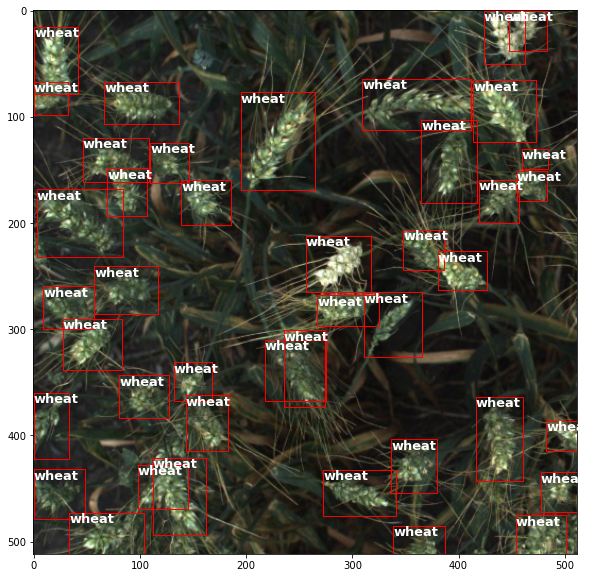

In [12]:
name = df.image_id.unique()[9]
loc = path+name+'.jpg'
aaa = df_grp.get_group(name)
bbx = aaa.loc[:,b_fea]
img = immg.imread(loc)
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img,cmap='binary')
for i in range(len(bbx)):
    box = bbx.iloc[i].values
    x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
    ax.text(*box[:2], "wheat", verticalalignment='top', color='white', fontsize=13, weight='bold')
    ax.add_patch(rect)
plt.show()

## Dataset

In [13]:
class WheatDataset(object):
    def __init__(self, df, IMG_DIR, transforms=None):
        # select only those classes that have boxes
        
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['image_id'].unique().tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_ids)
    
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df['image_id'] == image_id]
        image = cv2.imread(self.img_dir+image_id+".jpg",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros((records.shape[0],), dtype=torch.int64)
    
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return torch.tensor(image), target, image_id

## Transforms

In [ ]:
IMG_SIZE = (512,512)

In [14]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [15]:
img_dir = "../input/gwd-512-image-resized/"

In [16]:
WDS = WheatDataset(df, img_dir ,get_train_transform())

## Checking a Dataset Sample

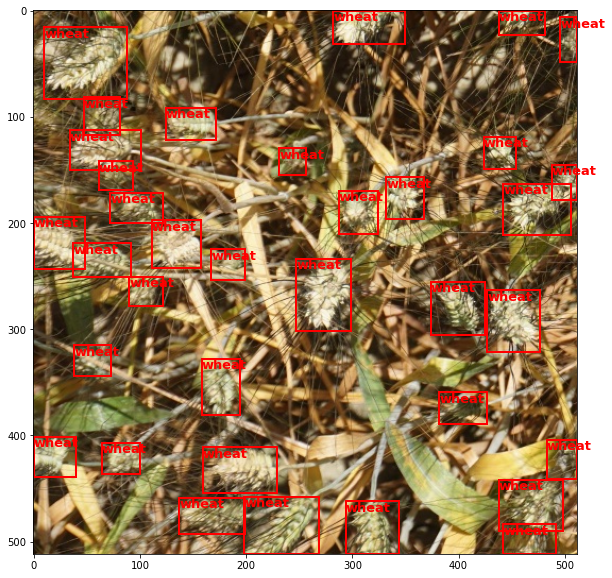

In [17]:
import random
img, tar,_ = WDS[random.randint(0,1000)]
bbox = tar['boxes'].numpy()
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for i in range(len(bbox)):
    box = bbox[i]
    x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
    ax.text(*box[:2], "wheat", verticalalignment='top', color='red', fontsize=13, weight='bold')
    ax.add_patch(rect)
plt.show()

In [18]:
image_ids = df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]
valid_df = df[df['image_id'].isin(valid_ids)]
train_df = df[df['image_id'].isin(train_ids)]
train_df.shape,valid_df.shape

((122787, 10), (25006, 10))

## DataLoader

In [19]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df,img_dir , get_train_transform())
valid_dataset = WheatDataset(valid_df,img_dir, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

<h2 align=center style="color:blue; border:1px dotted blue">Training</h2>

In [25]:
num_classes = 2  # 1 class (wheat) + background
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [26]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#lr_scheduler = None

## Averager

In [27]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

#### Below apply_nms function

**Performs non-maximum suppression (NMS) on the boxes according to their intersection-over-union (IoU).**

**NMS iteratively removes lower scoring boxes which have an IoU greater than iou_threshold with another (higher scoring) box.**

**If multiple boxes have the exact same score and satisfy the IoU criterion with respect to a reference box, the selected box is not guaranteed to be the same between CPU and GPU. This is similar to the behavior of argsort in PyTorch when repeated values are present.**

Source : https://pytorch.org/vision/stable/ops.html

In [28]:
# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.2):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

## Training

In [29]:
num_epochs = 2

In [30]:
loss_hist = Averager()
best_epoch = 0
min_loss = sys.maxsize
for epoch in range(num_epochs):
    loss_hist.reset()
    tk = tqdm(train_data_loader)
    model.train();
    for images, targets, image_ids in tk:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        tk.set_postfix(train_loss=loss_value)
    tk.close()
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}") 
    
    if loss_hist.value<min_loss:
        print("Better model found at epoch {0} with {1:0.5f} loss value".format(epoch,loss_hist.value))
        torch.save(model.state_dict(), f"model_state_epoch_{epoch}.pth")
        min_loss = loss_hist.value
        best_epoch = epoch
    #validation 
    model.eval();
    with torch.no_grad():
        tk = tqdm(valid_data_loader)
        for images, targets, image_ids in tk:
        
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            val_output = model(images)
            val_output = [{k: v.to('cpu') for k, v in t.items()} for t in val_output]
            IOU = []
            for j in range(len(val_output)):
                val_out = apply_nms(val_output[j])
                a,b = val_out['boxes'].cpu().detach(), targets[j]['boxes'].cpu().detach()
                chk = torchvision.ops.box_iou(a,b)
                res = np.nanmean(chk.sum(axis=1)/(chk>0).sum(axis=1))
                IOU.append(res)
            tk.set_postfix(IoU=np.mean(IOU))
        tk.close()
        
model.load_state_dict(torch.load(f"./model_state_epoch_{best_epoch}.pth"));

  0%|          | 0/339 [00:00<?, ?it/s]

Epoch #0 loss: 0.9647974298680637
Better model found at epoch 0 with 0.96480 loss value


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/339 [00:00<?, ?it/s]

Epoch #1 loss: 0.8484826786115702
Better model found at epoch 1 with 0.84848 loss value


  0%|          | 0/84 [00:00<?, ?it/s]

In [ ]:
#model.load_state_dict(torch.load('../input/global-wheat-detection-pytorch-starter-easy/model_state_epoch_5.pth'));

<h2 align=center style="color:blue; border:1px dotted blue">Analyze</h2>

## Validation And Prediction

In [32]:
img,target,_ = valid_dataset[50]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['boxes']))
print('real #boxes: ', len(target['boxes']))

predicted #boxes:  56
real #boxes:  53


### Ground Truths

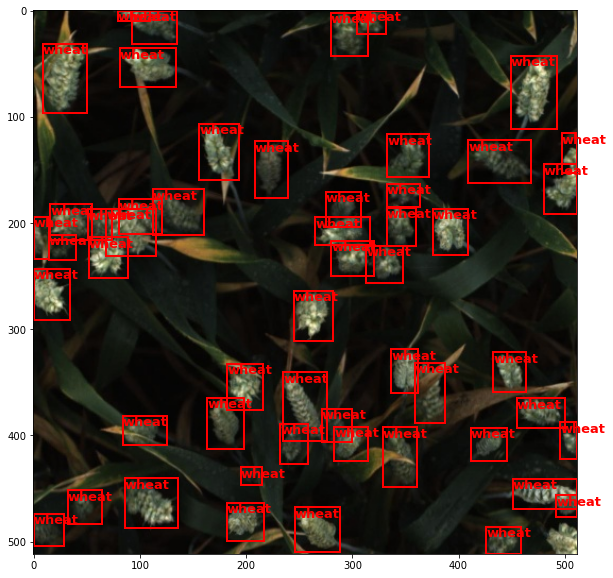

In [33]:
bbox = target['boxes'].numpy()
fig,ax = plt.subplots(1,figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for i in range(len(bbox)):
    box = bbox[i]
    x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
    ax.text(*box[:2], "wheat", verticalalignment='top', color='red', fontsize=13, weight='bold')
    ax.add_patch(rect)
plt.show()

In [34]:
def plot_valid(img,prediction,nms=True,detect_thresh=0.5):
    fig,ax = plt.subplots(figsize=(18,10))
    val_img = img.permute(1,2,0).cpu().numpy()
    ax.imshow(val_img)
    nms_prediction = apply_nms(prediction, iou_thresh=0.2) if nms else prediction
    val_scores = nms_prediction['scores'].cpu().detach().numpy()
    bbox = nms_prediction['boxes'].cpu().detach().numpy()
    for i in range(len(bbox)):
        if val_scores[i]>=detect_thresh:
            box = bbox[i]
            x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
            rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2 ,edgecolor='r',facecolor='none',)
            ax.text(*box[:2], "wheat {0:.3f}".format(val_scores[i]), verticalalignment='top', color='white', fontsize=12, weight='bold')
            ax.add_patch(rect)
    plt.show()

### Predictions on valid set

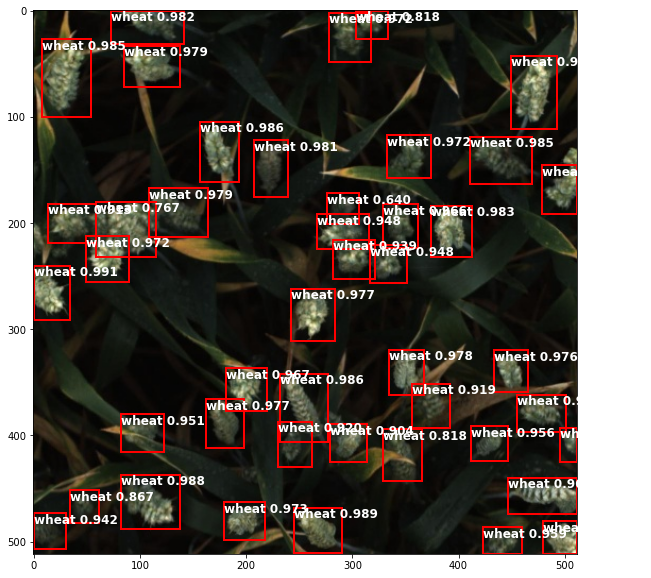

In [35]:
plot_valid(img,prediction)

<h2 align=center style="color:blue; border:1px dotted blue">Predictions on Test Dataset</h2>

In [36]:
submission = pd.read_csv('../input/global-wheat-detection/sample_submission.csv')

In [48]:
class TestDataset(object):
    def __init__(self, df, IMG_DIR, transforms=None):
        # select only those classes that have boxes
        
        self.df = df
        self.img_dir = IMG_DIR
        self.transforms = transforms
        self.image_ids = self.df['image_id'].tolist()
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        
        image_id = self.image_ids[idx]
        image = cv2.imread(self.img_dir+image_id+".jpg",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        #image /= 255.0
        
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

In [49]:
def get_test_transform(IMG_SIZE=(512,512)):
    return A.Compose([
         A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        A.Resize(*IMG_SIZE),
        ToTensorV2(p=1.0)
    ])

In [50]:
test_img_dir = '../input/global-wheat-detection/test/'

In [51]:
IMG_SIZE = (512,512)

In [52]:
test_dataset = TestDataset(submission, test_img_dir ,get_test_transform(IMG_SIZE))

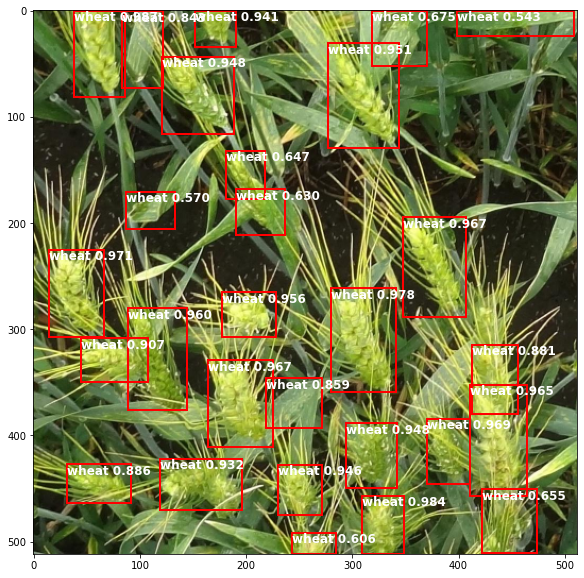

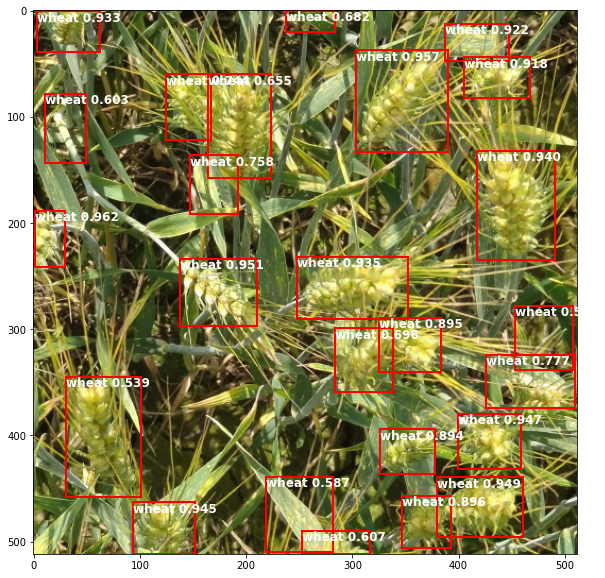

In [ ]:
for j in range(submission.shape[0]):
    img,_ = test_dataset[j]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
    plot_valid(img,prediction)